!! This is the code from https://www.kaggle.com/code/tumpanjawat/s3e19-course-eda-fe-lightgbm/notebook.
I have tried to solve the dataset prediction problem on my own(From 2024-02-17 to 2024-02-22). I have made some works on my own, such as doing EDA myself and discover seasonality pattern. I built a XGBoostRegressor model and found that the model preforms well in X_train, y_train. However, since the training period is from 2017-01-01 to 2020-10-31, and I found some overfitting problem related to this model.

Since I don't know how to solve the problem of my prototype, I am asking new solutions for help. 

# Getting Started
## 🚀 Getting Started
This project involves analyzing a retail sales dataset with the aim of predicting future sales. The dataset includes various `Features` related to sales data, including date, country, product, and store identifiers. Each entry represents a unique sale, and the features include date-related attributes (like year, month, day, and day of the week), country, product, and store identifiers.
## 🎯 Objective
Our main objective is to develop a predictive model that can effectively forecast future sales based on the provided features. By leveraging the power of the Light Gradient Boosting Machine, we aim to enhance the model's accuracy and predictive performance.
## 📈 Workflow
Here's a brief overview of our workflow for this project:

1. **Data Loading and Preprocessing**: Load the data and preprocess it for analysis and modeling. This includes converting date columns to datetime format and extracting additional date-related features.

2. **Exploratory Data Analysis (EDA)**: Perform exploratory data analysis to gain insights into the dataset, understand the distributions of features, and explore potential relationships between the features and sales.

3. Feature Engineering: Perform feature engineering to extract additional relevant features or transform existing features to improve the model's performance.

4. Model Training and Validation: Train the LightGBM model using a GroupKFold cross-validation strategy and make predictions on the test set.

5. Sales Disaggregation: Disaggregate the forecasted total sales into product-level sales using historical sales ratios.

6. Model Evaluation: Evaluate the performance of the trained model using appropriate evaluation metrics and assess the model's ability to generalize to unseen data using the test set.

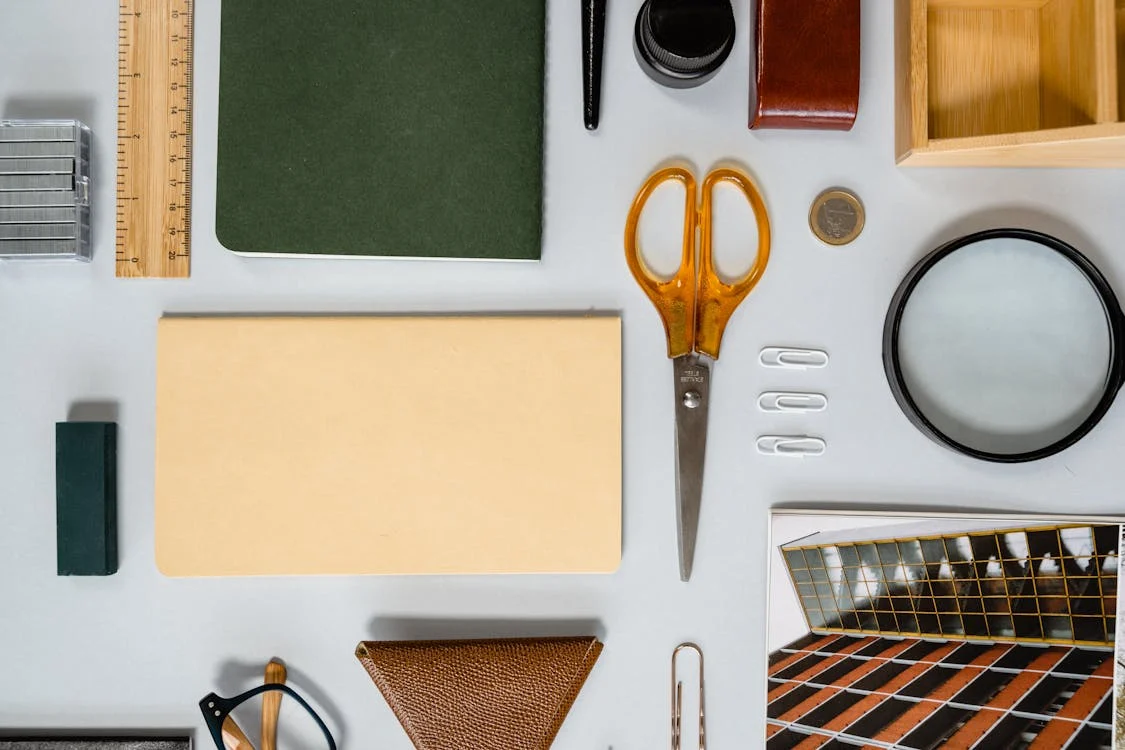



## Domain Knowledge 📚
Let's dive into the domain knowledge of the features used in this project:

Features
date: This is the date when the sales were recorded. Dates are fundamental in sales forecasting as sales tend to have temporal patterns such as trends (sales increasing or decreasing over time) and seasonality (patterns repeating at regular intervals, like daily, weekly, monthly, quarterly, or yearly). For instance, retail sales often increase during holiday seasons or on specific days of the week.

country: This is the country where the sales were recorded. Country can be an important feature in sales forecasting as sales patterns often vary between countries due to factors like cultural differences, economic conditions, or different holidays.

product: This is the identifier of the product that was sold. Different products might have different sales patterns. For example, some products might sell more during certain seasons (like swimsuits in the summer or coats in the winter), while others might have steady sales throughout the year.

store: This is the identifier of the store where the sales were recorded. Different stores might have different sales patterns due to factors like location, size, customer demographics, or management practices.

Year, Month, Day, WeekDay: These are features derived from the date feature. They represent the year, month, day of the month, and day of the week of the sales, respectively. These features can help capture temporal trends and seasonality in the sales data. For example, sales might be higher on weekends (day of the week), during holiday seasons (month), or during specific years due to economic trends.

`holiday_name`, `is_holiday_`: These features represent the name of the holiday (if any) on the date of the sales, and whether the date was a holiday. Holidays often influence sales patterns, with sales typically increasing during holiday seasons.

`ratios`: This feature represents the historical ratios of product sales, used for disaggregating total sales into product-level sales. The assumption here is that the proportion of sales for each product will remain relatively stable over time. If this assumption holds, these ratios can be a useful tool for generating more detailed forecasts.

## 📝 Abstract
This project presents an in-depth exploration and modeling of a retail sales dataset, with the primary objective of predicting sales at the product level 🎯. The dataset is characterized by a variety of Features 📊 including 'date' 📆, 'store' 🏪, 'country' 🌍, 'product' 📦, 'Year' 📅, 'Month' 📆, 'Day' 🗓️, 'WeekDay' 📅, and other engineered features capturing temporal patterns ⏳, cyclical trends 🔄, and special events (holidays) 🎉.

Our exploratory data analysis revealed significant **temporal patterns** in sales, hinting at the influence of time ⏰ and special events 🎉 on the number of items sold. Additionally, we identified some **anomalies** in the data related to the period from March 2020 to May 2020, suggesting the need for robust anomaly detection 🕵️‍♀️ and handling methods in retail sales forecasting.

We harnessed the potential of ensemble models, specifically the LightGBM Regressor 🚀, to predict total sales. The model was meticulously trained and validated using a GroupKFold cross-validation strategy 🔄, yielding variable scores across different folds.

The sales forecasts produced by the model were then disaggregated into product-level forecasts using historical sales ratios 📈. This approach assumes the stability of product sales ratios over time ⏳.

The project highlights the potential of machine learning 🧠 in retail sales forecasting, providing insights that could assist in inventory management 🗃️, sales planning 📝, and business strategy formulation 💼. Future efforts could focus on refining the predictive model 🔍, exploring different strategies for sales disaggregation 🧩, and integrating additional external data sources 🔄 to enhance the accuracy and detail of sales forecasts 📈.

### I | Import neccessary libraries¶

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D



### II | Input the Data

In [3]:
data = pd.read_csv('./train.csv')

### III | Get to know the Data

In [5]:
print("Numerical data description:")
display(data.describe())
print("Categorical data description:")
display(data.describe(include='O'))

Numerical data description:


,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


Categorical data description:


,date,country,store,product
count,136950,136950,136950,136950
unique,1826,5,3,5
top,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
freq,75,27390,45650,27390


### Categorical Variables: 🔠
1. **date:** 🗓️ There are 1,826 unique dates in the dataset, which range from 1-1-2017 to 31-12-2022.

2. **country:** 🌍 There are 5 unique countries, with Argentina appearing most frequently.

3. **store:** 🏬 There are 3 unique stores, with "Kaggle Learn" being the most common.

4. **product:** 📦 There are 5 unique products, with "Using LLMs to Improve Your Coding" being the most sold.

### Getting started with Sales Data Analysis

This project focuses on analyzing the [Sales dataset](#) to identify key factors associated with sales trends. By utilizing techniques such as univariate and bivariate analysis, as well as time series methods like rolling window analysis , we aim to uncover valuable insights into the complex relationships within the data.

---
<blockquote>
Our analysis provides valuable insights into the factors influencing sales trends. However, it's crucial to interpret these findings with caution, recognizing the distinction between correlation and causation. It is important to note that our exploratory analysis, although comprehensive, does not establish a causal relationship between the provided features and sales trends.
</blockquote>

---


Let's explore and then make results and discussion to gain deeper insights from our analysis. 🧐🔍

### Trend of Sales Over Time

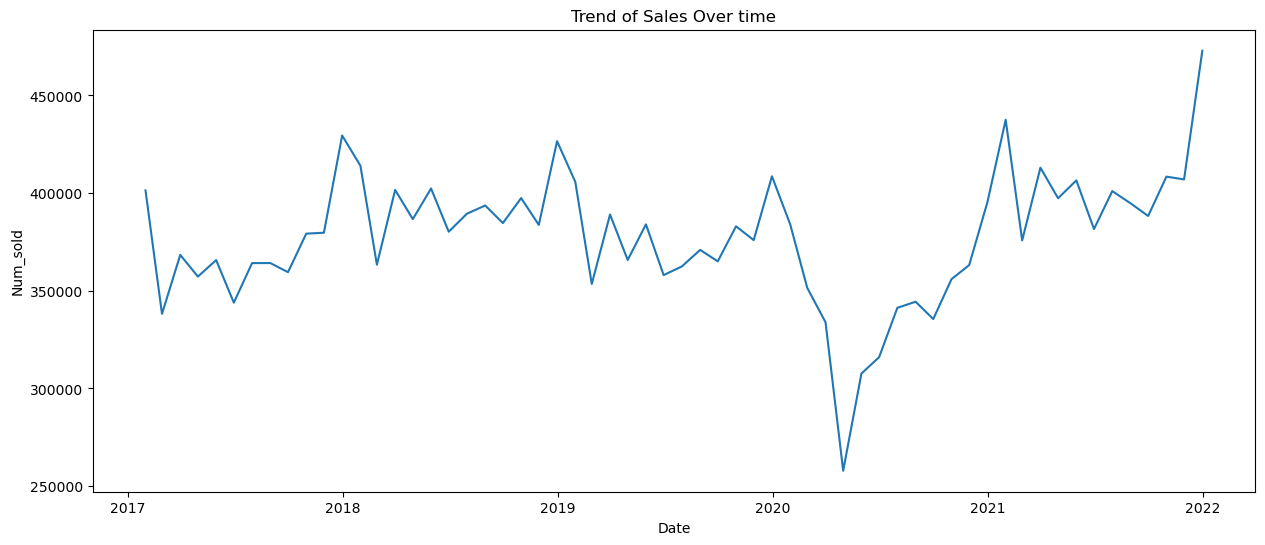

In [16]:
# Convert `date` to datetime format
data['date'] = pd.to_datetime(data['date'])

# Aggregate sales on a monthly basis
monthly_sales = data.resample('M',on='date').sum()['num_sold']
# Plot the trend of sales over time
plt.figure(figsize=(15,6))
sns.lineplot(x=monthly_sales.index,
         y=monthly_sales.values)
plt.title('Trend of Sales Over time')
plt.xlabel("Date")
plt.ylabel('Num_sold')
plt.show()

### Intepret the Results 📊
The line plot shows the trend of sales over time, aggregated on a monthly basis. It seems that the sales have some sort of seasonality, with peaks and troughs appearing regularly.

> There also seems to be an overall increasing trend in the number of products sold over time.

### What's next 🤔
**Let's calculate a 7-day and a 30-day rolling mean of the sales and visualize them. A 7-day rolling mean will give us a weekly trend, while a 30-day rolling mean will give us a monthly trend. Please note that for this analysis, we will consider the daily total sales across all countries, stores, and products.**

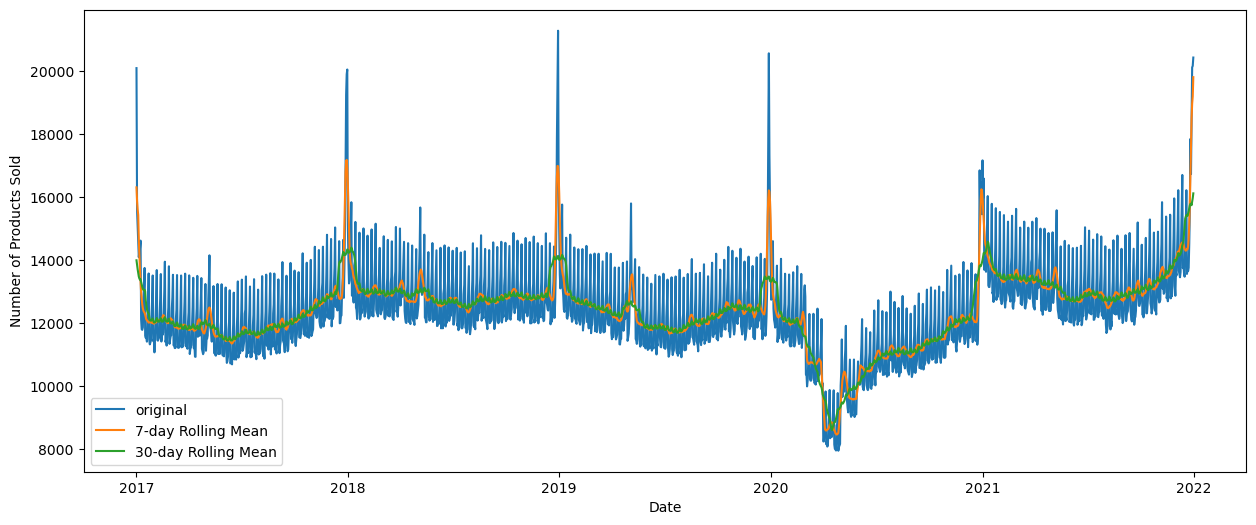

In [18]:
daily_sales = data.resample('D',on='date').sum()['num_sold']

daily_sales_rolling_7d = daily_sales.rolling(window=7,
                                             min_periods=3,
                                             center=True
                                             ).mean()
daily_sales_rolling_30d =daily_sales.rolling(window=30,
                                             min_periods=15,
                                             center=True
                                             ).mean()
plt.figure(figsize=(15,6))
sns.lineplot(
    x = daily_sales.index,
    y = daily_sales.values,
    label = 'original',
)
sns.lineplot(
    x = daily_sales_rolling_7d.index,
    y = daily_sales_rolling_7d.values,
    label = '7-day Rolling Mean'
)
sns.lineplot(
    x = daily_sales_rolling_30d.index,
    y = daily_sales_rolling_30d.values,
    label = '30-day Rolling Mean'
)
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.legend()
plt.show()